In [1]:
import numpy as np
from tqdm import tqdm
from itertools import product
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tq

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
plt.rcParams['font.family'] = 'AppleGothic'

import scipy.stats
import itertools
import warnings 
import os
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
warnings.filterwarnings(action='ignore')
from pmdarima.arima import ndiffs
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

In [10]:
df=pd.read_csv('/Users/kang-yumin/Desktop/DATA(입주물량 수정).csv/남양주시.csv')
df['날짜']=pd.to_datetime(df['날짜'])
#df=df.drop('날짜.1',axis=1)
df['평당가']= df['평당가'].astype('int')
df['GTX']= df['GTX'].astype('category')
df['신도시']= df['신도시'].astype('category')
df['LTV']= df['LTV'].astype('category')
#df['강남접근성점수']= df['강남접근성점수'].astype('category')
#df['강남자가용점수']= df['강남자가용점수'].astype('category')
df.set_index('날짜', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 170 entries, 2008-04-01 to 2022-05-01
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   평당가        170 non-null    int64   
 1   연령평균       170 non-null    float64 
 2   가구수        170 non-null    int64   
 3   사설학원수(개)   170 non-null    int64   
 4   학업성취도      170 non-null    float64 
 5   매매회전율      170 non-null    float64 
 6   미분양수       170 non-null    int64   
 7   입주물량       170 non-null    int64   
 8   강남접근성점수    170 non-null    int64   
 9   강남자가용점수    170 non-null    int64   
 10  GTX        170 non-null    category
 11  신도시        170 non-null    category
 12  LTV        170 non-null    category
 13  UIG        170 non-null    float64 
 14  출퇴근량       170 non-null    int64   
 15  대기업수       170 non-null    int64   
 16  매수우위지수     170 non-null    float64 
 17  가계대출금리     170 non-null    float64 
 18  미국금리종가     170 non-null    float64 
 19  epu       

In [11]:
df.head()

,평당가,연령평균,가구수,사설학원수(개),학업성취도,매매회전율,미분양수,입주물량,강남접근성점수,강남자가용점수,...,LTV,UIG,출퇴근량,대기업수,매수우위지수,가계대출금리,미국금리종가,epu,선도50지수,주택가격전망CSI
날짜,,,,,,,,,,,,,,,,,,,,,
2008-04-01,969,3.3,114165,670,71.9,1.361875,2393,460,2,2,...,1,2.79,60596,1,59.5,6.99,3.734,74.095062,33.9,89
2008-05-01,1001,3.3,114459,670,71.9,1.107502,2268,460,2,2,...,1,2.84,60596,1,60.3,6.95,4.067,89.214928,34.3,89
2008-06-01,1016,3.1,114717,670,71.9,1.172074,2241,460,2,2,...,1,2.86,60596,1,57.1,6.93,3.975,125.871094,34.8,89
2008-07-01,707,3.7,114988,670,71.9,1.200446,2227,460,2,2,...,1,2.91,60596,1,46.2,7.12,3.958,126.503624,35.5,101
2008-08-01,916,3.1,115220,670,71.9,0.641803,1465,460,2,2,...,1,2.81,60596,1,39.4,7.35,3.825,110.481140,36.2,101


#### 변수 제거

In [12]:
df = df.drop(['연령평균','가구수','학업성취도','사설학원수(개)','출퇴근량','강남접근성점수','강남자가용점수','가계대출금리',
                'GTX','신도시','LTV','대기업수','대기업수','매수우위지수','미국금리종가','선도50지수','주택가격전망CSI'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 170 entries, 2008-04-01 to 2022-05-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   평당가     170 non-null    int64  
 1   매매회전율   170 non-null    float64
 2   미분양수    170 non-null    int64  
 3   입주물량    170 non-null    int64  
 4   UIG     170 non-null    float64
 5   epu     170 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 9.3 KB


### 데이터 분할

In [13]:
df

,평당가,매매회전율,미분양수,입주물량,UIG,epu
날짜,,,,,,
2008-04-01,969,1.361875,2393,460,2.79,74.095062
2008-05-01,1001,1.107502,2268,460,2.84,89.214928
2008-06-01,1016,1.172074,2241,460,2.86,125.871094
2008-07-01,707,1.200446,2227,460,2.91,126.503624
2008-08-01,916,0.641803,1465,460,2.81,110.481140
...,...,...,...,...,...,...
2022-01-01,3533,0.079795,10,279,4.67,228.802427
2022-02-01,3161,0.082336,11,279,4.75,270.153319
2022-03-01,3064,0.111307,16,279,4.90,364.996204


In [15]:
def datasplit(raw, y_colname, x_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    y_train = raw_train[y_colname]
    x_train = raw_train[x_colname]
    y_test = raw_test[y_colname]
    x_test = raw_test[x_colname]
    return x_train, x_test, y_train, y_test

y_colname =['평당가']  
x_colname=['입주물량','UIG', '매매회전율', '미분양수', 'epu']
x_train, x_test, y_train, y_test = datasplit(df,y_colname, x_colname,'2021-01-01' )

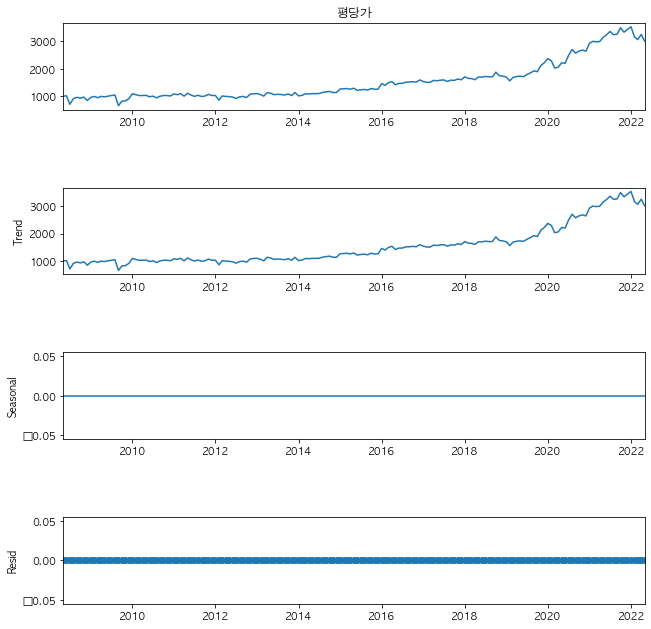

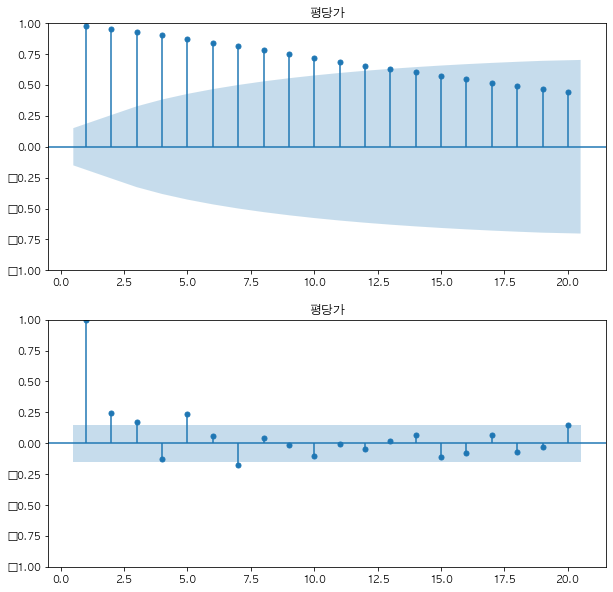

(0.8390906192905614,
 0.9922416649426817,
 6,
 162,
 {'1%': -3.471374345647024,
  '5%': -2.8795521079291966,
  '10%': -2.5763733302850174},
 1836.855849959766)

In [16]:
##Decompose
decomposition =seasonal_decompose(df["평당가"][1:], period =1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

## ACF, PACF
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(df["평당가"][1:], lags = 20, zero = False, ax=ax1)
ax1.set_title("평당가") ##MA5


sgt.plot_pacf(df['평당가'][1:], lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("평당가") ##AR5

fig.set_size_inches(10,10)
plt.show()

## ADF
sts.adfuller(df["평당가"][1:]) ##p-value : ?

In [17]:
df_diff = df.diff(1).dropna()

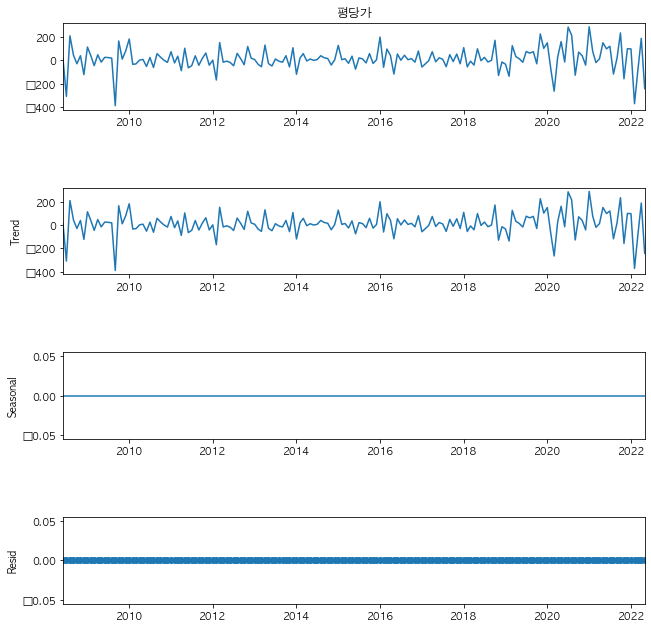

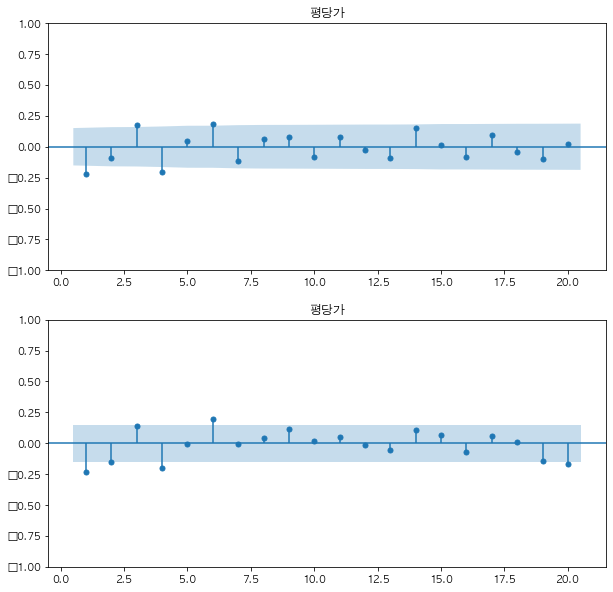

(-4.525811280679854,
 0.00017656761445721065,
 5,
 162,
 {'1%': -3.471374345647024,
  '5%': -2.8795521079291966,
  '10%': -2.5763733302850174},
 1824.7011959307924)

In [18]:
##Decompose
decomposition =seasonal_decompose(df_diff["평당가"][1:], period =1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

## ACF, PACF
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(df_diff["평당가"][1:], lags = 20, zero = False, ax=ax1)
ax1.set_title("평당가") ##MA5


sgt.plot_pacf(df_diff['평당가'][1:], lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("평당가") ##AR5

fig.set_size_inches(10,10)
plt.show()

## ADF
sts.adfuller(df_diff["평당가"][1:]) ##p-value : ?

In [19]:
model = pm.auto_arima(y = y_train, d = 1, start_p = 0 , max_p = 7, start_q = 0, max_q = 7,
    m = 1 , seasonal = True , stepwise = True, trace=True )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1794.574, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1787.848, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1786.194, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1794.957, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1786.577, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1787.235, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1788.720, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1788.879, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.551 seconds


In [20]:
model.fit(y_train)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [21]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  153
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -890.097
Date:                Fri, 26 Aug 2022   AIC                           1786.194
Time:                        10:39:55   BIC                           1795.266
Sample:                             0   HQIC                          1789.879
                                - 153                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.0789      5.342      2.074      0.038       0.608      21.550
ma.L1         -0.2849      0.067     -4.250      0.000      -0.416      -0.154
sigma2      7138.8496    457.534     15.603      0.0

In [22]:
model= sm.tsa.SARIMAX(y_train, exog = x_train, order=(0,1,1))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78190D+00    |proj g|=  3.26900D-02

At iterate    5    f=  5.78147D+00    |proj g|=  1.01728D-03

At iterate   10    f=  5.78144D+00    |proj g|=  4.85412D-03

At iterate   15    f=  5.78030D+00    |proj g|=  1.78702D-02

At iterate   20    f=  5.77991D+00    |proj g|=  2.61854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     25      1     0     0   1.401D-04   5.780D+00
  F =   5.7799109614826607     

CONVERG

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    평당가   No. Observations:                  153
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -884.326
Date:                Fri, 26 Aug 2022   AIC                           1782.653
Time:                        10:39:56   BIC                           1803.820
Sample:                    04-01-2008   HQIC                          1791.252
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
입주물량          -0.1003      0.047     -2.143      0.032      -0.192      -0.009
UIG           31.2903     37.086      0.844      0.399     -41.397     103.978
매매회전율       -129.6956     22.617     -5.734      0.000    -174.024     -85.368
미분양수          -0.0010      0.037     -0.027      0.978      -0.073       0.071
epu            0.0289      0.133      0.218      0.827      -0.231       0.289
ma.L1         -0.1696      0.068     -2.511      0.012      -0.302      -0.037
sigma2      6627.8035    616.289     10.754      0.000    5419.899    7835.708
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                42.75
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                            -0.41
Prob(H) (two-sided):                  0.33   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

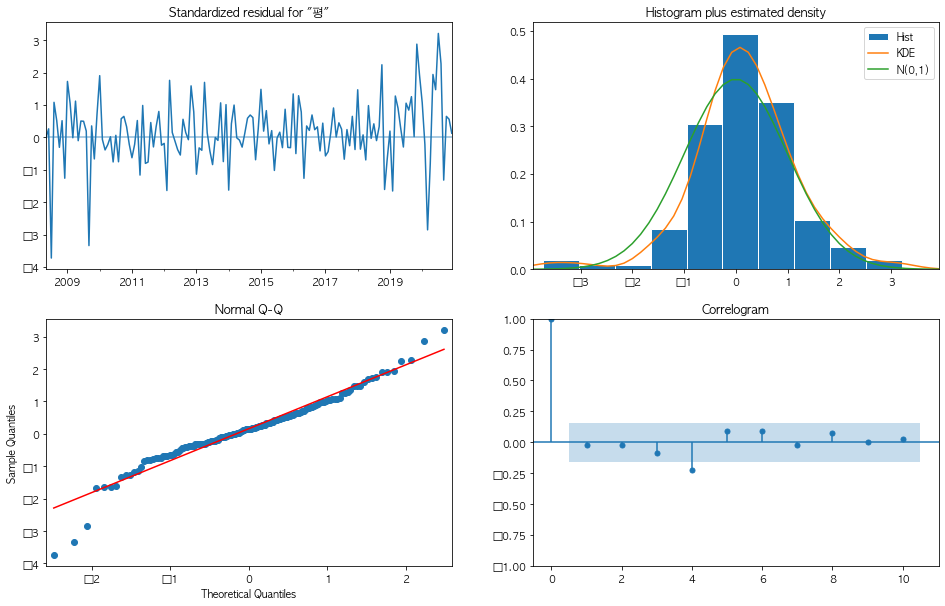

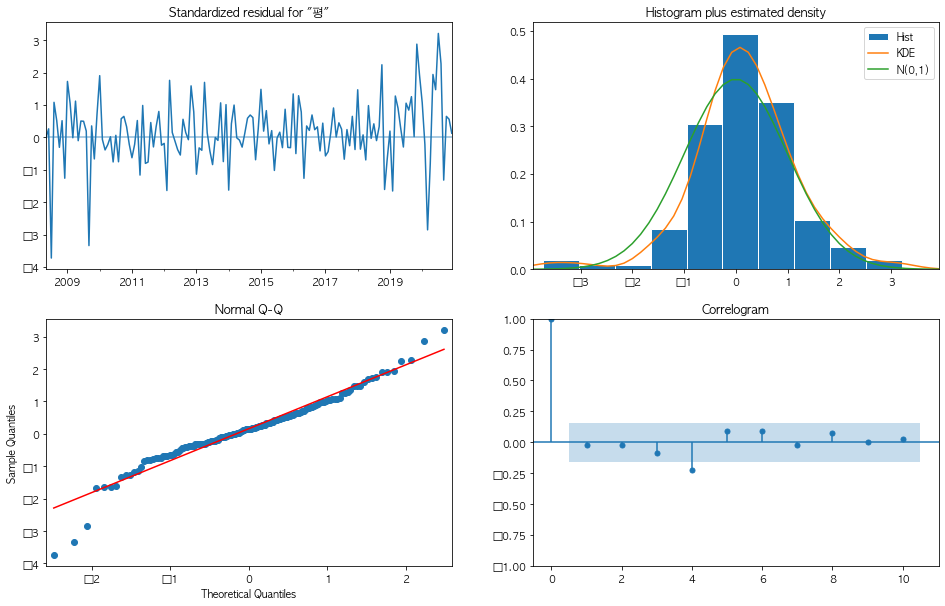

In [23]:
results.plot_diagnostics(figsize=(16, 10))

In [24]:
x = df.iloc[:,1:]
y = df.iloc[:,0]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95888D+00    |proj g|=  2.15309D-02

At iterate    5    f=  5.95862D+00    |proj g|=  4.39812D-03

At iterate   10    f=  5.95817D+00    |proj g|=  4.83683D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     15      1     0     0   9.352D-06   5.958D+00
  F =   5.9581597458217939     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


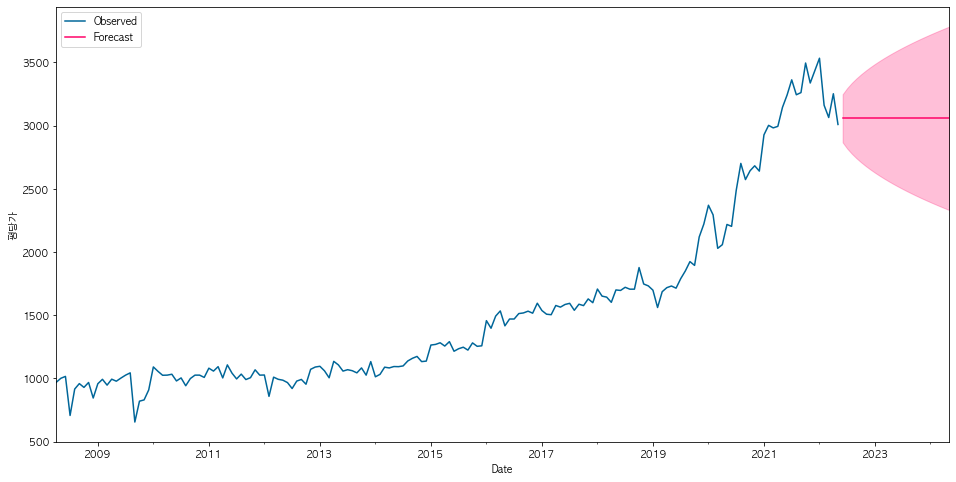

In [25]:
## Build model and fit

res = sm.tsa.statespace.SARIMAX(y,
                                order=(0,1,1),
                                seasonal_order=(0,0,0,0),
                            enforce_stationarity=True,
                                enforce_invertibility=True).fit()


## Get forecast 120 steps ahead in future
pred_uc = res.get_forecast(steps=24)

## Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

## Plot time series and long-term forecast
ax = y.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date')
ax.set_ylabel('평당가')
plt.legend(loc='upper left')
plt.show()

In [26]:
from pmdarima.arima import auto_arima

In [27]:
model = auto_arima(y_train, exogenous=x_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=x_train)

forecast = model.predict(n_periods=len(y_test), exogenous=x_test)
#df["Forecast"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1781.477, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1784.219, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1780.601, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1780.313, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1784.809, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1780.638, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1781.609, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1784.231, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1782.653, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.341 seconds


<AxesSubplot:xlabel='날짜'>

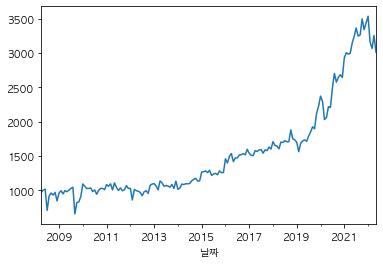

In [28]:
y.plot()

In [29]:
model = pm.auto_arima(y = y_train        # 데이터
                      , d = 1
                      , exogenous=x_train # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 5   
                      , start_q = 0 
                      , max_q = 5   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1784.219, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1780.601, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1780.313, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1784.809, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1780.638, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1781.609, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1784.231, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1782.653, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.021 seconds


In [30]:
model.fit(y_train, exogenous=x_train)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [31]:
forecast = model.predict(n_periods=len(y_test), exogenous=x_test)
#df_test["Forecast_ARIMAX"] = forecast

In [32]:
y_test["Forecast"] = forecast

In [33]:
y_test

,평당가,Forecast
날짜,,
2021-01-01,2927,2620.340924
2021-02-01,3002,2647.673126
2021-03-01,2982,2691.948110
2021-04-01,2994,2738.630958
2021-05-01,3144,2758.971333
2021-06-01,3242,2786.885432
2021-07-01,3362,2795.181435
2021-08-01,3244,2798.976843
2021-09-01,3261,2824.780945


RMSE of Auto ARIMAX: 395.9053594325604

MAE of Auto ARIMAX: 356.6438871830287


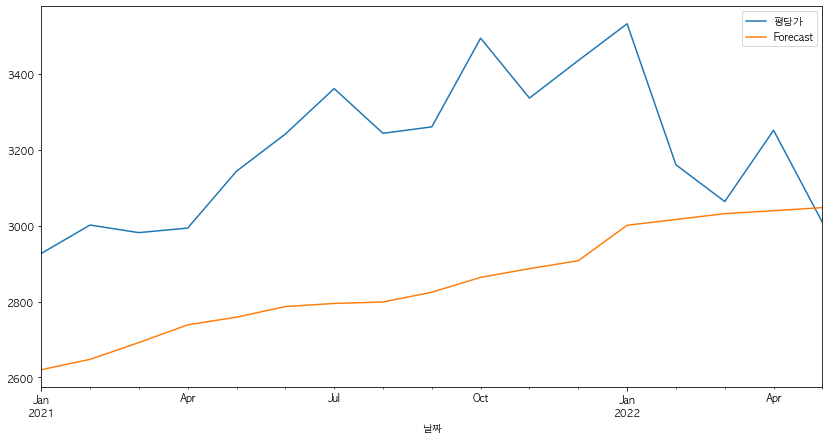

In [34]:
y_test[["평당가", "Forecast"]].plot(figsize=(14, 7))

from sklearn.metrics import mean_absolute_error, mean_squared_error
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(y_test.평당가, y_test.Forecast)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(y_test.평당가, y_test.Forecast))